# **Exploratory Data Analysis**
* Previousely, We examined the various tables in the database to identify key variables, understand, their realationships, and determine which one should be inclueded in final analysis.
* In this phase, We are exploring the resultant table to gain insights into the distribution of each column.
* This will enable us to discover underlying patterns and valuable insights.

>### **Importing Libraries**

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

>### **Connecting with MySQL Data-Base**

In [18]:
from sqlalchemy import create_engine

"""Connection Details"""

user = "root"  # your MySQL username
password = "tictok#2020"
host = "localhost"  # your MySQL server IP
port = "3306"
database = "contoso_sales"

try:
    engine = create_engine(
        f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}"
    )
except Exception as exc:
    print("Error while connecting to mysql", exc)

>### **Loading Data-Set**

In [19]:
sql_query = """
    SELECT * FROM sales_summary;
"""

df = pd.read_sql(sql=sql_query, con=engine)
df.head()

,id,dates,channel,brand,product_category,country,return_amount,discount_amount,total_cost,total_sales,net_sales,net_profit
0,1,2007-01-01,Store,Contoso,Audio,China,0.00,6.47,66.00,129.42,122.95,56.95
1,2,2007-01-01,Store,Contoso,Audio,United Kingdom,299.23,119.69,793.12,2393.84,1974.92,1181.80
2,3,2007-01-01,Store,Contoso,Audio,United States,0.00,14.96,892.26,2693.07,2678.11,1785.85
3,4,2007-01-01,Store,Wide World Importers,Audio,Romania,0.00,0.00,305.80,599.80,599.80,294.00
4,5,2007-01-01,Store,Wide World Importers,Audio,Slovenia,149.95,29.99,305.80,599.80,419.86,114.06


>### **Data Structrue Overview**

In [4]:
# Shape of the Data-Set
df.shape

(348484, 12)

In [5]:
# Checking for duplicate values
df.duplicated().sum()

np.int64(0)

In [6]:
# Shows columns, Null values and Data Type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348484 entries, 0 to 348483
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                348484 non-null  int64  
 1   dates             348484 non-null  object 
 2   channel           348484 non-null  object 
 3   brand             348484 non-null  object 
 4   product_category  348484 non-null  object 
 5   country           348484 non-null  object 
 6   return_amount     348484 non-null  float64
 7   discount_amount   348484 non-null  float64
 8   total_cost        348484 non-null  float64
 9   total_sales       348484 non-null  float64
 10  net_sales         348484 non-null  float64
 11  net_profit        348484 non-null  float64
dtypes: float64(6), int64(1), object(5)
memory usage: 31.9+ MB


In [164]:
# Checking for number of unique values in each feature or column
df.nunique().sort_values()

channel                  4
product_category         8
brand                   11
country                 34
dates                 1096
return_amount         6904
total_sales          15811
total_cost           18826
discount_amount      37447
net_sales           115758
net_profit          120561
id                  348484
dtype: int64

>### **Data Cleaning & Handling Missing Values**

In [8]:
# Converting Dates column to date time format
df["dates"] = pd.to_datetime(df["dates"], errors="coerce")

In [9]:
# Removing duplicate if present
df.drop_duplicates(inplace=True)

In [10]:
# Checking for null values
df.isnull().sum().sort_values(ascending=False)

id                  0
dates               0
channel             0
brand               0
product_category    0
country             0
return_amount       0
discount_amount     0
total_cost          0
total_sales         0
net_sales           0
net_profit          0
dtype: int64

>### **Handling Outliers**

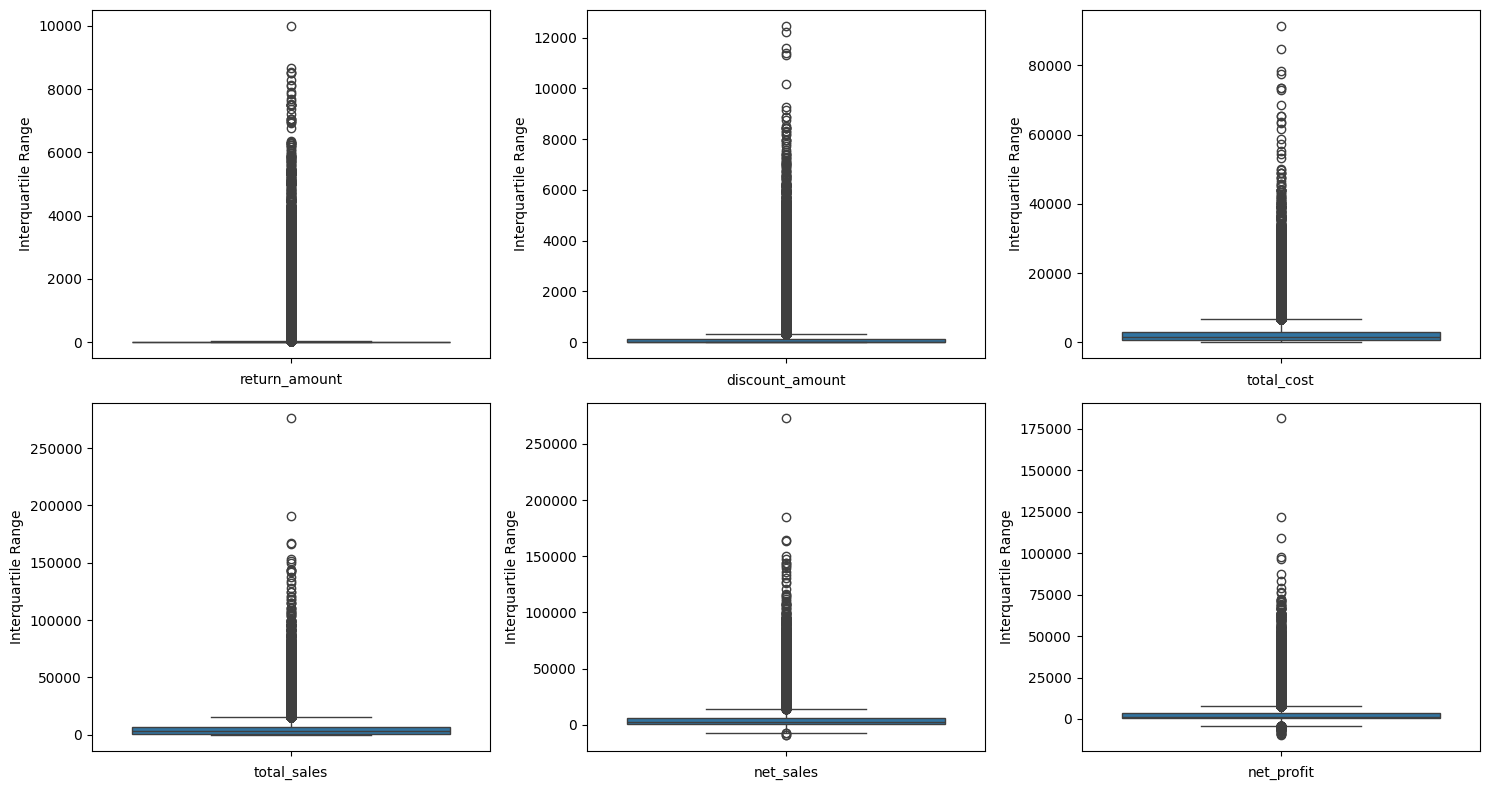

In [11]:
# Box plots to show if outliers are present
numerical_cols = df.select_dtypes(include=["float64"]).columns

plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)  # Adjust Grid layout as needed
    sns.boxplot(y=df[col])
    plt.xlabel(col)
    plt.ylabel("Interquartile Range")
plt.tight_layout()
plt.show()

##### Observations :
- Outliers are present in all numerical columns.

In [12]:
# Function to check for outliers using IQR method
def has_outliers(data_column):
    Q1 = data_column.quantile(0.25)
    Q3 = data_column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    outliers = data_column[(data_column < lower_bound) | (data_column > upper_bound)]
    return outliers


outliers_return_amount = has_outliers(df["return_amount"])
outliers_discount_amount = has_outliers(df["discount_amount"])
outliers_total_cost = has_outliers(df["total_cost"])
outliers_total_sales = has_outliers(df["total_sales"])
outliers_net_sales = has_outliers(df["net_sales"])
outliers_net_profit = has_outliers(df["net_profit"])

In [13]:
# Filling missing value
def fill_missing_value(df, column, outliers):
    if not outliers.empty:
        df[column] = df[column].fillna(df[column].median())
    else:
        df[column] = df[column].fillna(df[column].mean())


fill_missing_value(df, "return_amount", outliers_return_amount)
fill_missing_value(df, "discount_amount", outliers_discount_amount)
fill_missing_value(df, "total_cost", outliers_total_cost)
fill_missing_value(df, "total_sales", outliers_total_sales)
fill_missing_value(df, "net_sales", outliers_net_sales)
fill_missing_value(df, "net_profit", outliers_net_profit)

If outliers are present then this function will fill missing value with median, if not then mean.

>### **Summary Statstics**

In [14]:
df.describe()

,id,dates,return_amount,discount_amount,total_cost,total_sales,net_sales,net_profit
count,348484.000000,348484,348484.000000,348484.000000,348484.000000,348484.000000,348484.000000,348484.000000
mean,174242.500000,2008-06-10 02:22:15.273929728,118.343921,153.453132,2386.724938,5352.136380,5080.339328,2693.614389
min,1.000000,2007-01-01 00:00:00,0.000000,0.000000,1.920000,3.800000,-8791.870000,-9515.770000
25%,87121.750000,2007-09-07 00:00:00,0.000000,0.000000,521.640000,1079.910000,980.000000,457.390000
50%,174242.500000,2008-05-29 00:00:00,0.000000,15.960000,1427.400000,3055.200000,2899.890000,1450.800000
75%,261363.250000,2009-03-11 00:00:00,9.990000,135.982500,2985.600000,6730.000000,6412.150000,3445.840000
max,348484.000000,2009-12-31 00:00:00,9996.000000,12461.600000,91411.840000,275901.600000,272718.120000,181306.280000
std,100598.809942,NaN,371.478190,386.307736,3118.632076,7116.969491,6850.342649,3896.504499


#### Summary Statstics Insights :
+ Negative Values :
    - Net Profit: Minimum values is (-9515.77), indicating losses. Some products or transections may be selling at loss, due to high cost.
    - Profit Margin: Here minimum value is (-260665.22%), which indicates that there are some cases where revenue is lower than the cost. It can be due to heavy discount because cost of product is higher.
    - Net Sales : Here minimum values is (-8791.87), which indicates that there is heavy discount or returns.
+ Outliers Indicated by High Standard Deviations :
    - Total Cost & Total Sales : The maximum values are (91411.84) and (275901.6) respectively which is significantly higher than the mean (2386.72) and (5352.13), indicating potential premium products.

>### **Correlation Between Numerical Columns**

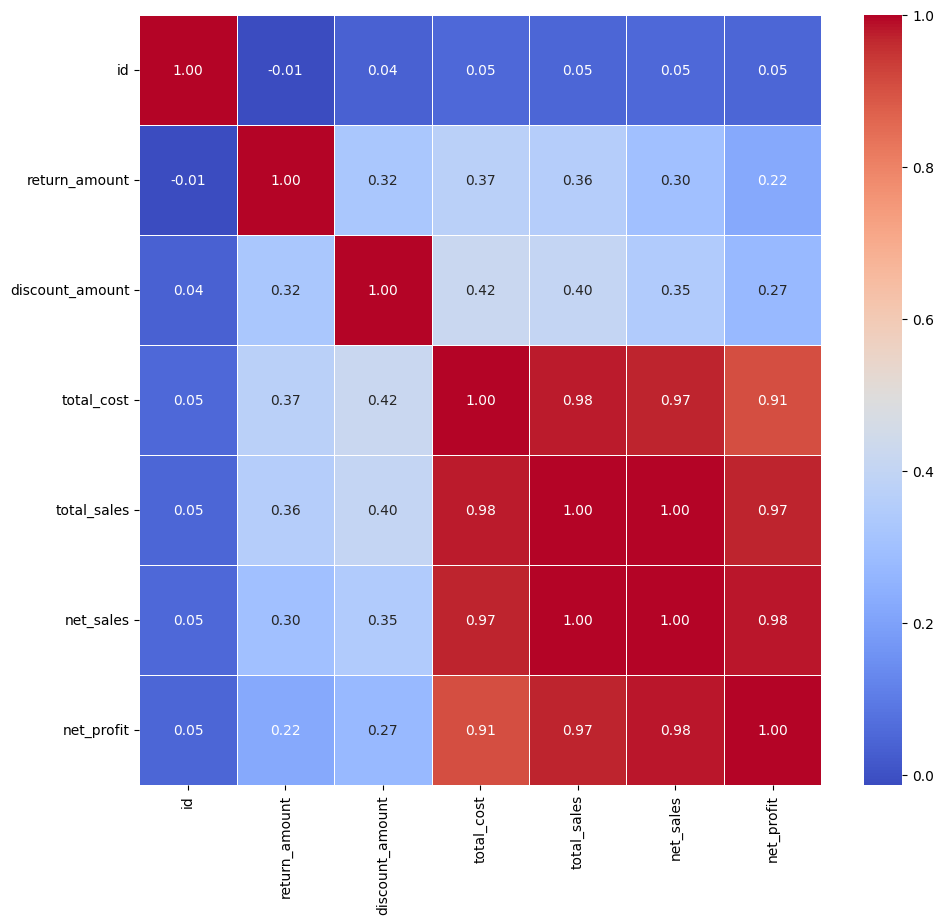

In [16]:
# correlation heatmap to find out relation between columns

plt.figure(figsize=(11, 10))
sns.heatmap(
    data=df.corr(numeric_only=True),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
)
plt.show()

#### Correlation Insights :
- Net Sales has weak correlation with Return Amount (0.30) and Discount Amount (0.35), which indicates that there is no significant impact of discounts and returns on sale. May be impact is seasonal, during holidays.
- There is very strong correlation between Total Cost and Total Sales (0.98), Indicating that profit margin will stay about the same.
- There is very strong positive correlation between Net Sales and Net Profit which means if sales is increasing, net profit also tends to increase proportionally. Indicating company effectively converting sales into profit.

>### **Data Analysis**

#### *Q1: Which product category and brands contribute most to net sales?*

In [ ]:
# Group by brand, aggregating net sales by sum

group_brand = (
    df.groupby(by=["brand"], as_index=False)
    .agg(net_sales=pd.NamedAgg(column="net_sales", aggfunc="sum"))
    .sort_values(by=["net_sales"], ascending=[False])
)
group_brand

,brand,net_sales
3,Fabrikam,3.848159e+08
2,Contoso,3.531667e+08
1,Adventure Works,2.238081e+08
10,Wide World Importers,1.682343e+08
6,Proseware,1.499641e+08
9,The Phone Company,1.057288e+08
4,Litware,9.674056e+07
0,A. Datum,9.578611e+07
5,Northwind Traders,8.929310e+07
7,Southridge Video,8.441259e+07


In [96]:
# Group by product category, aggregating net sales by sum

group_product = (
    df.groupby(by=["product_category"], as_index=False)
    .agg(net_sales=pd.NamedAgg(column="net_sales", aggfunc="sum"))
    .sort_values(by=["net_sales"], ascending=[False])
)
group_product

,product_category,net_sales
5,Home Appliances,5.220560e+08
1,Cameras and Camecorders,4.024139e+08
3,Computers,3.943503e+08
7,TV and Video,2.358952e+08
2,Cell Phones,1.373375e+08
0,Audio,2.948519e+07
6,"Music, Movies and Audio Books",2.493040e+07
4,Games and Toys,2.394846e+07


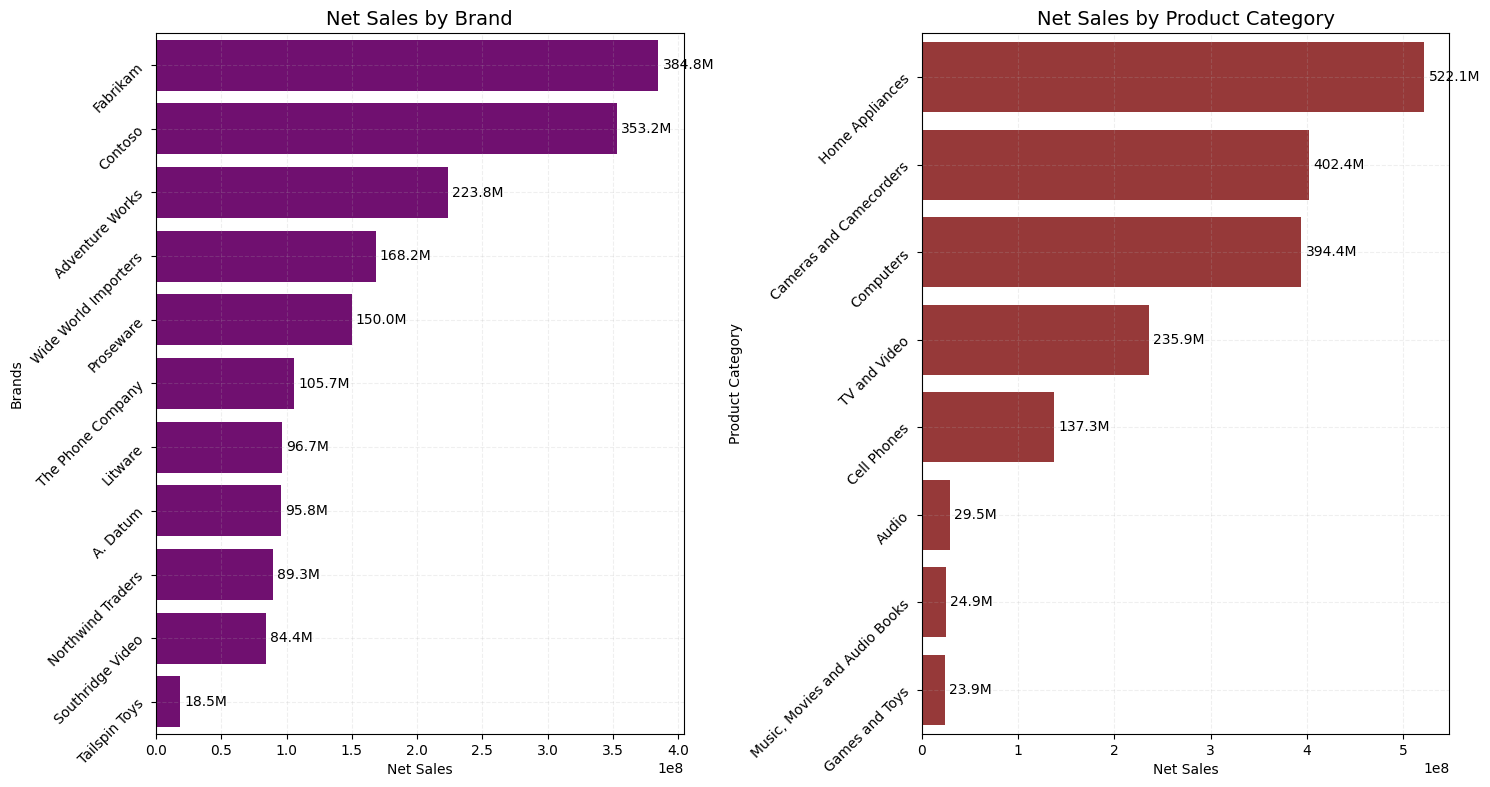

In [161]:
plt.figure(figsize=(15, 8))

# First subplot
ax1 = plt.subplot(1, 2, 1)
sns.barplot(data=group_brand, y="brand", x="net_sales", color="purple", ax=ax1)
plt.title("Net Sales by Brand", fontsize=14)
plt.xlabel("Net Sales")
plt.ylabel("Brands")
plt.yticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.2)

# Add formatted bar labels on first plot
for bar in ax1.patches:
    width = bar.get_width()
    label = f'{width / 1e6:.1f}M'  # Format number as X.XM
    ax1.annotate(label,
                 xy=(width, bar.get_y() + bar.get_height() / 2),
                 xytext=(3, 0),
                 textcoords='offset points',
                 ha='left', va='center')

# Second subplot
ax2 = plt.subplot(1, 2, 2)
sns.barplot(data=group_product, y="product_category", x="net_sales", color="brown", ax=ax2)
plt.title("Net Sales by Product Category", fontsize=14)
plt.xlabel("Net Sales")
plt.ylabel("Product Category")
plt.yticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.2)

# Add formatted bar labels on second plot
for bar in ax2.patches:
    width = bar.get_width()
    label = f'{width / 1e6:.1f}M'
    ax2.annotate(label,
                 xy=(width, bar.get_y() + bar.get_height() / 2),
                 xytext=(3, 0),
                 textcoords='offset points',
                 ha='left', va='center')

plt.tight_layout()
plt.show()

#### Observations :
+ Net Sales by Brand :
    - Identifies the brand Fabrikam (384.8M) as the primary driver of Sales, followed by Contoso (353.2M).
    - Fabrikam is more prominent among customers, It can be due to better quality, reputation or marketing.
    - Fabrikam have better pricing strategy, product innovation, distribution or brand loyality.
+ Net Sales by Product Category :
    - In product categories Home Appliances (522.1M) has the highest sales, followed by Cameras and Camecorders (402.4M).
    - Among customers Home Appliances are very populer, showing strong market preference.
    - Home Appliances may have better pricing, features, quality or brand perception.

#### *Q2: Which sales channels contribute the most to net profit?*

In [162]:
# Group by channel, aggregating net profit by sum

group_channel = (
    df.groupby(by="channel", as_index=False)
    .agg(
        net_profit=pd.NamedAgg(column="net_profit", aggfunc="sum"),
    )
    .sort_values(by="net_profit", ascending=False)
)

group_channel.head()

,channel,net_profit
3,Store,4.741180e+08
1,Online,2.189795e+08
2,Reseller,1.574502e+08
0,Catalog,8.813380e+07


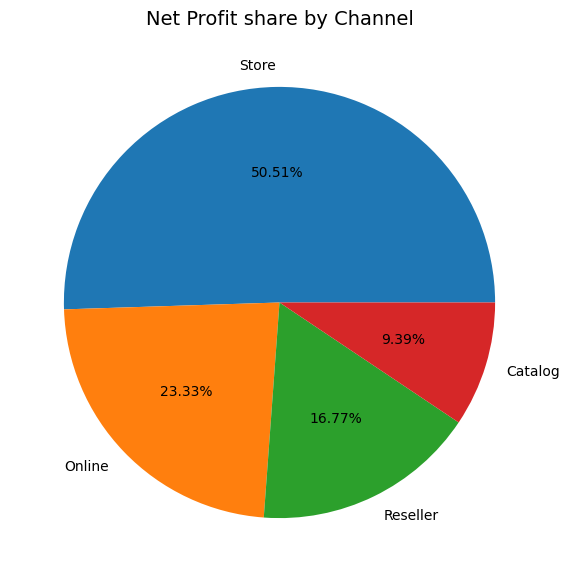

In [163]:
# Visualizaion of profit proportion for each channel

plt.figure(figsize=(10, 7))

plt.pie(data=group_channel, x="net_profit", labels="channel", autopct="%1.2f%%")
plt.title("Net Profit share by Channel", fontsize=14)
plt.show()

#### Observations :
+ Net Profit :
    - Store channel is generating most of the profit which is above 50% of Net Profit.
    - Likely due to higher sales volume despite having the smallest profit margin.
+ Profit Margin :
    - Reseller channel has the highest profit margin (25.29%) and the lowest profit margin (24.60%) is in Store.
    - Suggesting stable operational strategies and pricing models across sales channels.
    - Through out the channels diffarence between profit margin is very small, less than 1 percent point. But small difference in margin can be significant in large-scale operations.

#### *Q3: Which product category has the highest profit margin?*

In [ ]:
# Group by channel, aggregating net sales and net profit by sum

group_product = df.groupby(by="product_category", as_index=False).agg(
    net_profit=pd.NamedAgg(column="net_profit", aggfunc="sum"),
    net_sales=pd.NamedAgg(column="net_sales", aggfunc="sum"),
)
group_product["profit_margin"] = np.round(
    (group_product["net_profit"] / group_product["net_sales"]) * 100, 2
)
group_product.head()

,product_category,net_profit,net_sales,profit_margin
0,Audio,1.582378e+07,2.948519e+07,53.67
1,Cameras and Camecorders,2.285649e+08,4.024139e+08,56.80
2,Cell Phones,7.106283e+07,1.373375e+08,51.74
3,Computers,2.057494e+08,3.943503e+08,52.17
4,Games and Toys,1.231898e+07,2.394846e+07,51.44


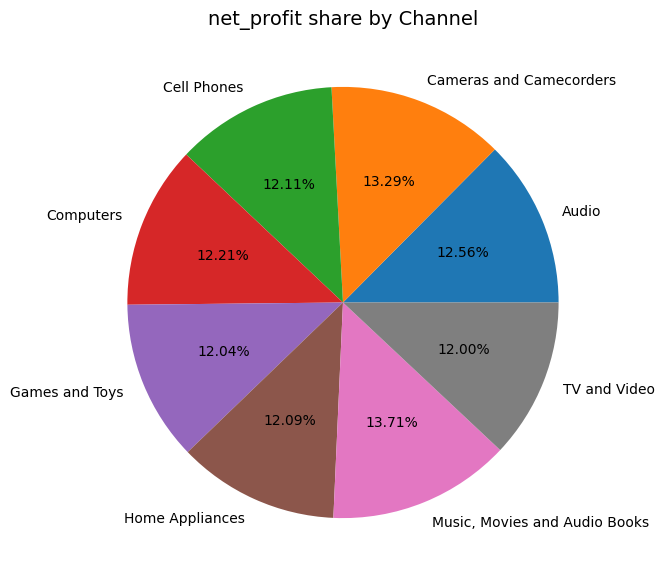

In [19]:
# Visualizaion of profit margin proportion for each product category

plt.figure(figsize=(10, 7))

plt.pie(
    data=group_product, x="profit_margin", labels="product_category", autopct="%1.2f%%"
)
plt.title(f"{col} share by Channel", fontsize=14)
plt.show()

#### Observations :
- Music, Movies and Audio Books product category has the highest Profit Margin (13.71%) and lowest the lowest profit margin (12%) in TV and Video product category.
- Indicating stable operational strategies and pricing models accross all Product Category.

#### *Q4: What is the proportion (percentage) of discount amount, return amount, total cost, net sales, and net profit contributed by each product category out of the company’s total for these metrics?*

In [21]:
# Group by Product Category, aggregating discount amount, return amount, total cost, net sales and net profit by sum

group_product = (
    df.groupby(by="product_category", as_index=False)
    .agg(
        discount_amount=pd.NamedAgg(column="discount_amount", aggfunc="sum"),
        return_amount=pd.NamedAgg(column="return_amount", aggfunc="sum"),
        total_cost=pd.NamedAgg(column="total_cost", aggfunc="sum"),
        net_sales=pd.NamedAgg(column="net_sales", aggfunc="sum"),
        net_profit=pd.NamedAgg(column="net_profit", aggfunc="sum"),
    )
    .sort_values(by="net_profit", ascending=False)
)

group_product.set_index(
    keys="product_category", inplace=True
)  # Now Product Category is Index


for col in group_product.columns:
    group_product[col] = np.round(
        ((group_product[col] / group_product[col].sum()) * 100), 2
    )

group_product

,discount_amount,return_amount,total_cost,net_sales,net_profit
product_category,,,,,
Home Appliances,36.41,36.56,30.35,29.49,28.72
Cameras and Camecorders,20.94,20.67,20.90,22.73,24.35
Computers,24.07,24.15,22.68,22.27,21.92
TV and Video,10.00,9.95,13.82,13.32,12.88
Cell Phones,5.17,5.18,7.97,7.76,7.57
Audio,1.14,1.17,1.64,1.67,1.69
"Music, Movies and Audio Books",1.41,1.44,1.24,1.41,1.56
Games and Toys,0.86,0.88,1.40,1.35,1.31


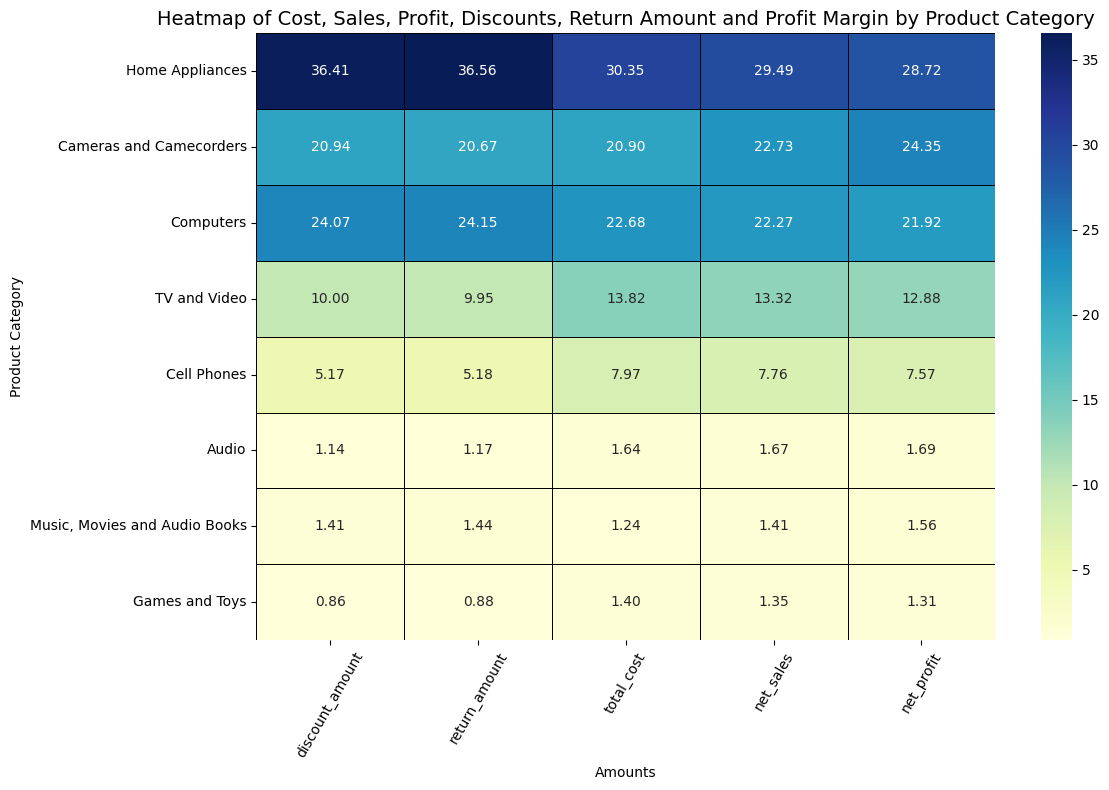

In [29]:
# Visualization of proportion of discount amount, return amount, total cost, net sales and net profit by Product Category
plt.figure(figsize=(12, 8))

sns.heatmap(
    data=group_product,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor="black",
)
plt.title(
    "Heatmap of Cost, Sales, Profit, Discounts, Return Amount and Profit Margin by Product Category",
    fontsize=14,
)
plt.xlabel("Amounts")
plt.xticks(rotation=60)
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()

#### Observations :
+ Discount Amount :
    - Home Appliances has highest discount among all product category (36.41%), followed by Computers (24.07%).
    - Discount is very high in Home Appliances category due to high sales price per unit.
+ Return Amount :
    - Home Appliances has highest returns among all product category (36.56%), followed by Computers (24.15%).
    - It may be due to product quality issue like defects, malfunctioned or unmat customer expectations.
    - Some categories are more susceptible to return fraud or policy abuse.
+ Total Cost :
    - Home Appliances has highest cost among all product category (30.35%), followed by Computers (22.68%).
    - Home Appliances has high sales volume.
    - Or cost of per unit is very high.
+ Net Sales :
    - Home Appliances has highest sales among all product category (29.49%), followed by Cameras and Camecorders (22.73%).
    - This is due to popularity among customers.
    - May warrant focused marketing efforts or investment.
+ Net Profit :
    - Home Appliances product category is generating the highest profit (28.72%), followed by Cameras and Camecorders (24.35%).
    - Likely due to higher sales volume because when compare to profit margin there is no significant difference.

#### *Q5: How discount amount and return amount impact net sales?*

In [22]:
# Creating column month_year for line plot

df["month_year"] = df["dates"].dt.to_period("M").astype(str)

In [23]:
# Group by month and year, aggregating net sales , discount amount and return amount by sum

group_month = df.groupby("month_year", as_index=False).agg(
    net_sales=pd.NamedAgg(column="net_sales", aggfunc="sum"),
    discount_amount=pd.NamedAgg(column="discount_amount", aggfunc="sum"),
    return_amount=pd.NamedAgg(column="return_amount", aggfunc="sum"),
)
group_month.head()

,month_year,net_sales,discount_amount,return_amount
0,2007-01,44682889.74,1853247.02,1148832.27
1,2007-02,45263332.69,1521657.71,1227966.95
2,2007-03,42749572.66,1559130.46,1207340.71
3,2007-04,52729688.72,624604.98,1456451.28
4,2007-05,55393851.81,343696.79,1584956.47


In [24]:
# Melt net sales, return amount and discount amount in long format, keeping "month_year" as ID

group_month_melt = group_month.melt(
    id_vars="month_year",
    value_vars=["net_sales", "return_amount", "discount_amount"],
    var_name="metric",
    value_name="amount",
)

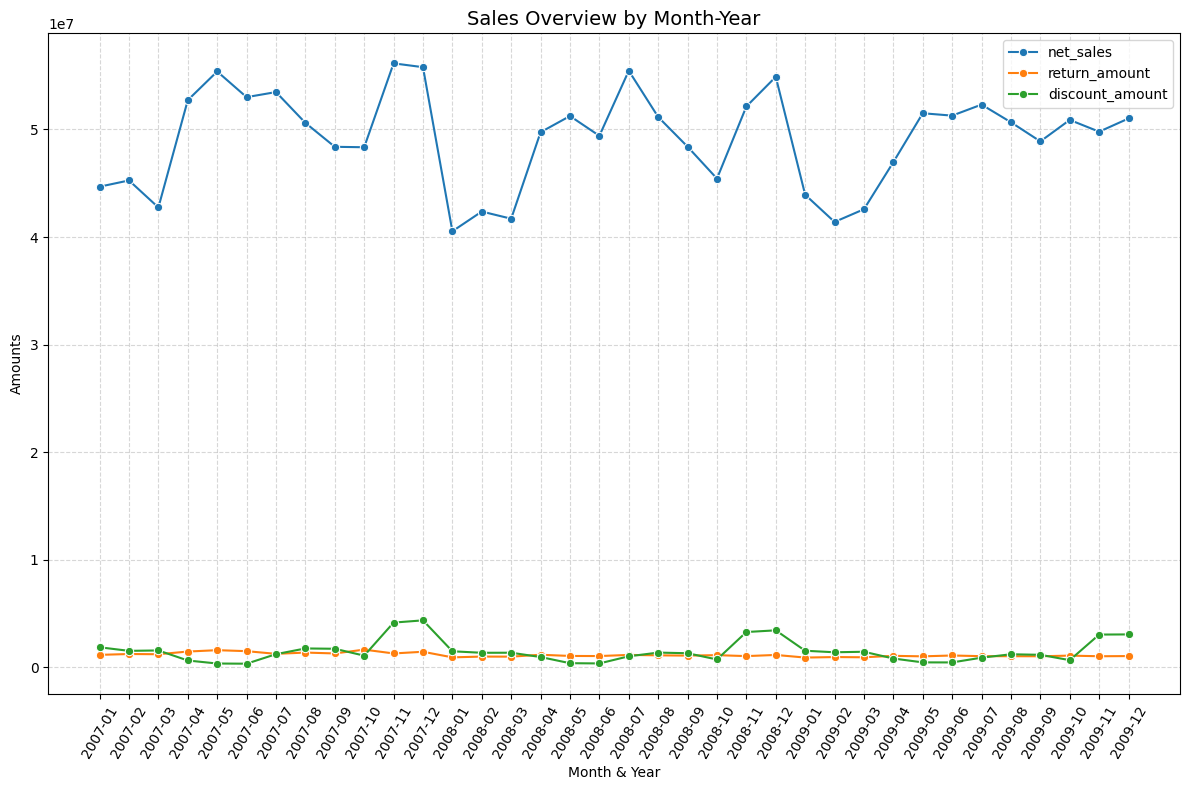

In [26]:
# Line plot to visulize impact of return amount and discount amount on sales

plt.figure(figsize=(12, 8))
sns.lineplot(
    data=group_month_melt, x="month_year", y="amount", hue="metric", marker="o"
)
plt.title("Sales Overview by Month-Year", fontsize=14)
plt.xlabel("Month & Year")
plt.xticks(rotation=60)
plt.ylabel("Amounts")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

#### Observations :
- Demonstrates that product returns exert minimal influence on overall sales trends.
- Highlights the significant positive impact of discount during the holiday season (November and December).
- Shows pronounced sales decline immidietly following the holiday period, around the New Year, reflecting moderated consumer spending.
- Reflects well-established seasonality patterns widely observed across the industry.

#### *Q6: How sales and profit trends vary across years and quarters?*

In [27]:
# Creating column quarter_year for line plot
df["quarter_year"] = df["dates"].dt.to_period("Q").astype(str)

In [28]:
# Group by quarter and year, aggregating net sales and net profit by sum
group_quarter = df.groupby(by="quarter_year", as_index=False).agg(
    net_sales=pd.NamedAgg(column="net_sales", aggfunc="sum"),
    net_profit=pd.NamedAgg(column="net_profit", aggfunc="sum"),
)

group_quarter.head()

,quarter_year,net_sales,net_profit
0,2007Q1,1.326958e+08,70885150.13
1,2007Q2,1.611322e+08,86081104.74
2,2007Q3,1.524859e+08,80430887.62
3,2007Q4,1.602943e+08,82261713.67
4,2008Q1,1.246122e+08,65839397.50


In [29]:
# Melt net sales and net profit in long format, keeping "quarter_year" as ID

group_quarter_melt = group_quarter.melt(
    id_vars="quarter_year",
    value_vars=["net_sales", "net_profit"],
    var_name="metric",
    value_name="amount",
)

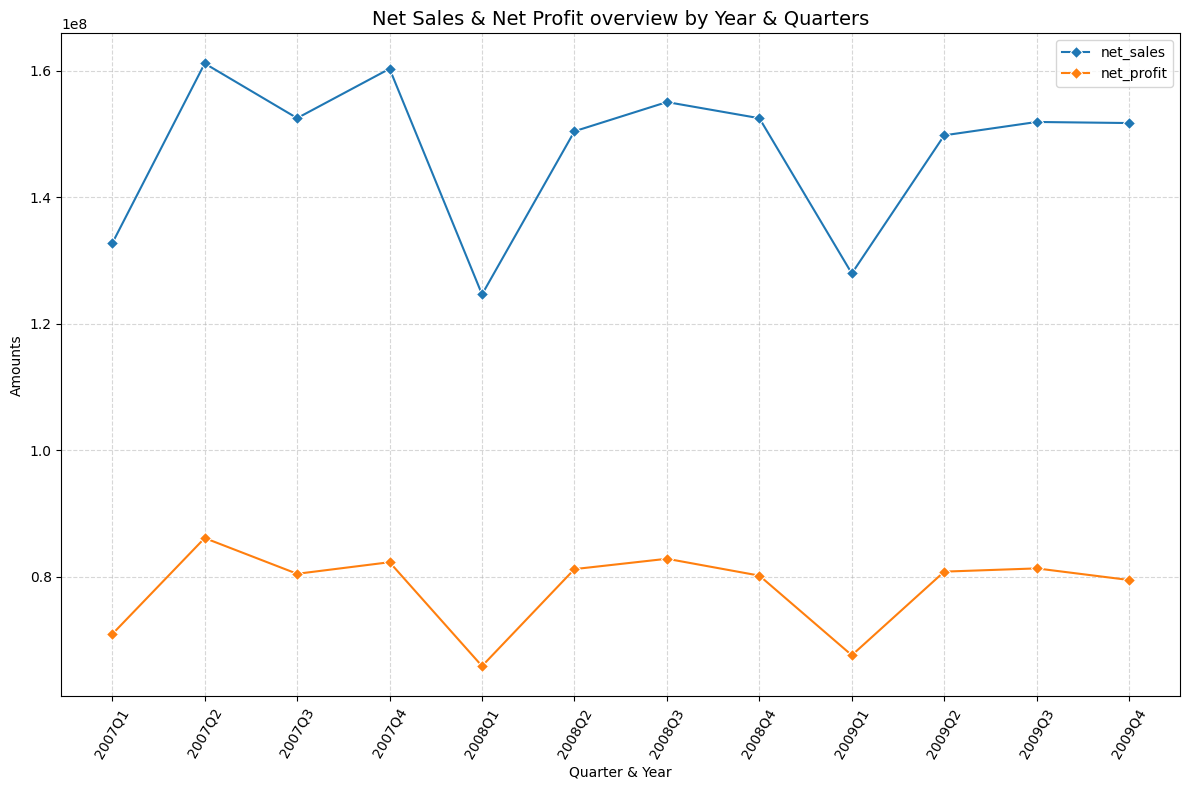

In [31]:
# Visulization of trend of net sales and net profit

plt.figure(figsize=(12, 8))
sns.lineplot(
    data=group_quarter_melt, x="quarter_year", y="amount", hue="metric", marker="D"
)
plt.title("Net Sales & Net Profit overview by Year & Quarters", fontsize=14)
plt.xlabel("Quarter & Year")
plt.xticks(rotation=60)
plt.ylabel("Amounts")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

#### Observations :
- In the above graph it clearly shows that net sales and net profit closely mirror each other.
- When net sales drop, profit typically drops because less revenue is generated and vice-versa.
- Profit Margin are fairely stable and profitablity is highly sensitive to sales fluctuations.

#### *Q7: Is profit margin improving or declining over time?*

In [32]:
group_month = df.groupby(by="month_year", as_index=False).agg(
    net_sales=pd.NamedAgg(column="net_sales", aggfunc="sum"),
    net_profit=pd.NamedAgg(column="net_profit", aggfunc="sum"),
)

group_month["profit_margin"] = (
    (group_month["net_profit"] / group_month["net_sales"]) * 100
).round(2)  # New Profit Margin Column

group_month.head()

,month_year,net_sales,net_profit,profit_margin
0,2007-01,44682889.74,24202827.39,54.17
1,2007-02,45263332.69,24138828.87,53.33
2,2007-03,42749572.66,22543493.87,52.73
3,2007-04,52729688.72,28319239.19,53.71
4,2007-05,55393851.81,29570984.32,53.38


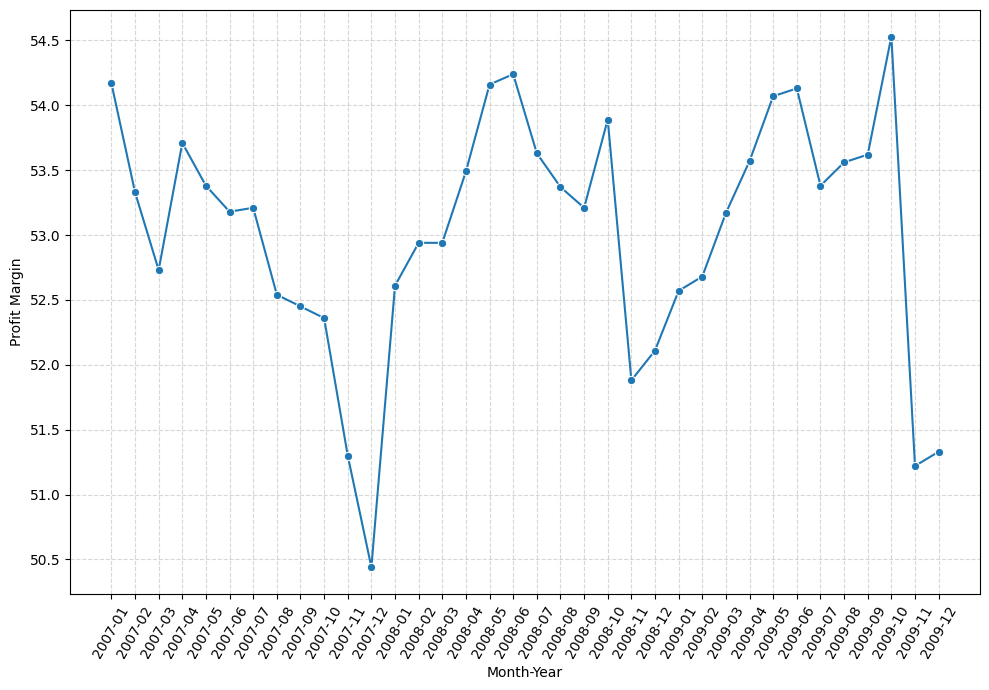

In [33]:
# Visulization of Profit Margin over time
plt.figure(figsize=(10, 7))
sns.lineplot(data=group_month, x="month_year", y="profit_margin", marker="o")
plt.xlabel("Month-Year")
plt.xticks(rotation=60)
plt.ylabel("Profit Margin")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

#### Oberservations :
- Competetive Pressure : Retailers feel pressure to offer promotions to win customers from competitiors, sacrificing margins to retain or grow market share.
- Consumer Expectations : Shoppers expect deals and are less loyal to brands, switching easily to find the best price.
- Inventory Clearence : Holidays are often used to clear out inventory, sometimes at the cost of profitablity.

#### *Q8: Which countries generate the highest revenue vs. profit margin?*

In [34]:
# Group by country, aggregating net sales and net profit by sum

group_country = (
    df.groupby("country", as_index=False)
    .agg(
        net_sales=pd.NamedAgg(column="net_sales", aggfunc="sum"),
        net_profit=pd.NamedAgg(column="net_profit", aggfunc="sum"),
    )
    .sort_values(by=["net_sales", "net_profit"], ascending=[False, False])
)

group_country["profit_margin"] = (
    (group_country["net_profit"] / group_country["net_sales"]) * 100
).round(2)  # new profit margin column

group_country.head()

,country,net_sales,net_profit,profit_margin
32,United States,7.587516e+08,3.865265e+08,50.94
4,China,2.800195e+08,1.504576e+08,53.73
7,Germany,1.671528e+08,8.938783e+07,53.48
6,France,1.178357e+08,6.369246e+07,54.05
31,United Kingdom,5.496434e+07,2.966755e+07,53.98


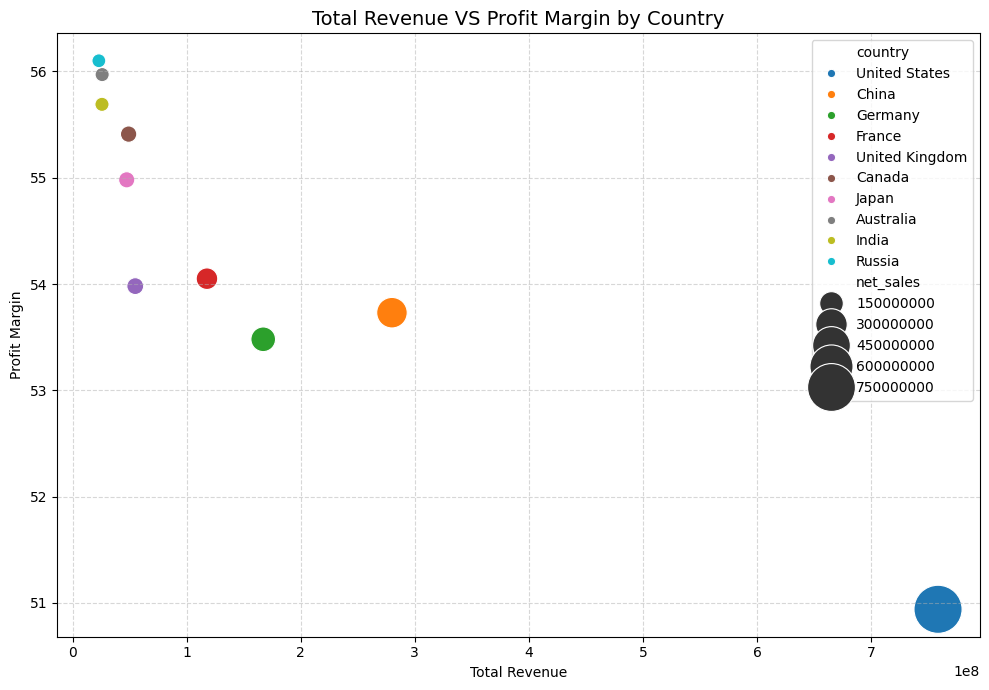

In [35]:
# Top 10 Sales VS Profit Margin by Country

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=group_country.head(10),
    x="net_sales",
    y="profit_margin",
    hue="country",
    size="net_sales",
    sizes=(100, 1200),
)
plt.title("Total Revenue VS Profit Margin by Country", fontsize=14)
plt.xlabel("Total Revenue")
plt.ylabel("Profit Margin")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

#### Observations :
- High Sales ≠ High Profitablity : United States has highest net sales, but lowest profit margin. This could be due to intense competition, higher cost and aggressive discounting.
- Cost Structures & Business Matter : High operational costs, supply chain challanges, pricing strategies, or local regulation can reduce the profit margins even where sales are strong.
- Consistent Business Model : This small range of profit margin indicate that the company has fairly consistent pricing and cost model accross these countries.